In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import gym
import collections
import cv2
import matplotlib.pyplot as plt
import time
import os

### step0. load the original env

In [2]:
# env_name = "ALE/Pong-v5"
env_name = "PongNoFrameskip-v4"
env = gym.make(env_name) # 1 means no frame skip

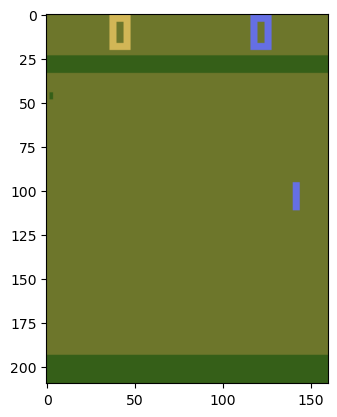

In [4]:
obs, info = env.reset()
plt.imshow(obs)

In [5]:
env.observation_space.sample().shape, env.observation_space.sample().dtype

((210, 160, 3), dtype('uint8'))

In [6]:
env.action_space.sample()

4

In [7]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [3]:
def play(env, policy_func=None, step_limit=10000):
    obs, info = env.reset()
    
    for step in range(step_limit):
        if policy_func:
            action = policy_func(obs)
        else:
            action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            env.close()
            print(f"Game over in {step+1} steps")
            return
    env.close()
    print(f"Time reached limit as {step_limit} steps")

In [29]:
play(gym.make(env_name, render_mode="human"))

Time reached limit as 1000 steps


### step1. build the wrapped env to suit training nn

In [4]:
class MaxAndSkipWrapper(gym.Wrapper):
    def __init__(self, env=None, skip=4, buffer_len=2):
        """return the max-pixel frame of the last 'buffer_len' frames only every 'skip' step"""
        super(MaxAndSkipWrapper, self).__init__(env)
        self.obs_buffer = collections.deque(maxlen=buffer_len)
        self.skip = skip
        
    def step(self, action):
        total_reward = 0.0
        terminated, truncated = None, None
        for _ in range(self.skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            self.obs_buffer.append(obs)
            total_reward += reward
            if terminated:
                break
        max_frame = np.max(np.stack(self.obs_buffer), axis=0)
        return max_frame, total_reward, terminated, truncated, info
    
    def reset(self):
        self.obs_buffer.clear()
        obs, info = self.env.reset()
        self.obs_buffer.append(obs)
        return obs, info

In [5]:
class FireResetWrapper(gym.Wrapper):
    def __init__(self, env=None):
        """Skip the first FIRE action when to reset"""
        super(FireResetWrapper, self).__init__(env)
        # check the actions, about whether the second action is 'FIRE', 
        # where the first action is always 'NOOP'
        # and check if there's another action more than these two
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3
    def reset(self):
        # directly pass through the first 'FIRE' action
        self.env.reset()
        obs, reward, terminated, truncated, info = self.env.step(1) # 'FIRE'
        if terminated:
            self.env.reset()
        obs, reward, terminated, truncated, info = self.env.step(2) # 'RIGHT'
        if terminated:
            self.env.reset()
        return obs, info

In [6]:
class FrameReshapeWrapper(gym.ObservationWrapper):
    def __init__(self, env=None):
        """reshape the img from (210,160,3) t0 (84,84,1)"""
        super(FrameReshapeWrapper, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84,84,1), dtype=np.uint8)
        
    def observation(self, obs):
        """change original obs to new one"""
        img = obs.astype(np.float32)
        img = img[:,:,0] * 0.299 + img[:,:,1] * 0.587 + img[:,:,2] * 0.114 # shape=(210,160,1)
        img = cv2.resize(img, (84,110), interpolation=cv2.INTER_AREA)
        img = img[18:102, :]
        img = np.reshape(img, [84,84,1])
        return img.astype(np.uint8)

In [7]:
class ChannelTransWrapper(gym.ObservationWrapper):
    def __init__(self, env=None):
        """transpose the channel dim from 2 to 0"""
        super(ChannelTransWrapper, self).__init__(env)
        ori_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=(ori_shape[-1], ori_shape[0], ori_shape[1]), # HWC => CHW
            dtype=np.float32
        )
        
    def observation(self, obs):
        return np.moveaxis(obs, 2, 0) # HWC => CHW

In [8]:
class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env=None, n_steps=4):
        """extend the channel dim from C to C*n_steps to store n_steps consecutive frames"""
        super(BufferWrapper, self).__init__(env)
        self.observation_space = gym.spaces.Box( # CHW => [C*n_steps]HW
            env.observation_space.low.repeat(n_steps, axis=0),
            env.observation_space.high.repeat(n_steps, axis=0),
            dtype=np.float32
        )
        
    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=np.float32)
        obs, info = self.env.reset()
        return self.observation(obs), info
    
    def observation(self, obs):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = obs
        return self.buffer

In [9]:
class NormalizeWrapper(gym.ObservationWrapper):
    def observation(self, obs):
        """normalize [0, 255] to [0.0, 1.0]"""
        return np.array(obs).astype(np.float32) / 255.0

In [10]:
def make_wrapped_env(env_name, render_mode=None):
    env = gym.make(env_name, frameskip=1, render_mode=render_mode)
    # refine
    env = MaxAndSkipWrapper(env)
    env = FireResetWrapper(env)
    # reshape
    env = FrameReshapeWrapper(env)
    env = ChannelTransWrapper(env)
    # buffer 
    env = BufferWrapper(env)
    # normalize
    env = NormalizeWrapper(env)
    
    return env

In [11]:
wrapped_env = make_wrapped_env(env_name)

In [12]:
wrapped_env.observation_space

Box(0.0, 1.0, (4, 84, 84), float32)

In [39]:
play(make_wrapped_env(env_name, render_mode="human"))

Game over in 901 steps


### step2. build the neural network

In [13]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions, dueling=False):
        super().__init__()
        # convolutional layer
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_shape = self._get_conv_out_shape(input_shape) # flatten shape
        # linear layer
        self.dueling = dueling
        if dueling: # Dueling DQN: Q(s,a) = V(s) + A(s,a)
            self.fc_val = nn.Sequential( # V(s)
                nn.Linear(conv_out_shape, 512),
                nn.ReLU(),
                nn.Linear(512, 1)
            )
            self.fc_adv = nn.Sequential( # A(s,a)
                nn.Linear(conv_out_shape, 512),
                nn.ReLU(),
                nn.Linear(512, n_actions)
            )
        else:
            self.fc = nn.Sequential(
                nn.Linear(conv_out_shape, 512),
                nn.ReLU(),
                nn.Linear(512, n_actions)
            )
        
    def _get_conv_out_shape(self, input_shape):
        # pseudoly pass the conv layer and get the output shape
        conv_out = self.conv(torch.zeros(1, *input_shape))
        return int(np.prod(conv_out.size()))
    
    def forward(self, obs):
        """output is the Q value of each action for this observation obs"""
        conv_out = self.conv(obs)
        fc_in = conv_out.view(obs.size()[0], -1) # flatten
        if self.dueling:
            val = self.fc_val(fc_in)
            adv = self.fc_adv(fc_in)
            return val + adv - adv.mean() # - adv.mean() to ensure advantage function has 0 mean value
        else:
            fc_out = self.fc(fc_in)
        
        return fc_out

### step3. build the DQN agent

In [14]:
Experience = collections.namedtuple('Experience', field_names=[
    'state', 'action', 'reward', 'done', 'next_state'
])
        
class ExperienceBuffer:
    def __init__(self, buffer_size=10000):
        """The buffer to store the latest 'buffer_size' experiences to sample the training data
        where one experience is a 5 elem tuple: (state, action, reward, is_done, next_state)
        """
        self.buffer = collections.deque(maxlen=buffer_size)
        
    def __len__(self):
        return len(self.buffer)
    
    def append(self, exp):
        self.buffer.append(exp)
    
    def sample(self, batch_size=32):
        idxs = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in idxs])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

In [15]:
class DQNAgent:
    def __init__(self, env_name, gamma=0.99, buffer_size=10000, device="cuda:0", 
                 lr=1e-4, double=False, dueling=False,
                 epsilon_start=1.0, epsilon_end=0.02, epsilon_decay=1e5
                ):
        """DQN Agent with epsilon greedy search policy"""
        self.gamma, self.double, self.dueling = gamma, double, dueling
        self.eps_start, self.eps_end, self.eps_decay = epsilon_start, epsilon_end, epsilon_decay
        self.eps = self.eps_start
        self.device = device
        self.env = make_wrapped_env(env_name)
        self.exp_buffer = ExperienceBuffer(buffer_size)
        self.net, self.target_net = self._make_net(), self._make_net()
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self._reset_env()
        
    def __str__(self):
        if not self.double and not self.dueling:
            return "DQNAgent with basic DQN"
        if self.double and self.dueling:
            return "DQNAgent with Dueling Double DQN"
        if self.double:
            return "DQNAgent with Double DQN"
        if self.dueling:
            return "DQNAgent with Dueling DQN"
        
        return "DQNAgent with DQN"
        
        
    def _make_net(self):
        input_shape = self.env.observation_space.shape
        n_actions = self.env.action_space.n
        
        return DQN(input_shape, n_actions, dueling=self.dueling).to(self.device)
        
    def _reset_env(self):
        self.state, info = self.env.reset()
        self.total_reward = 0.0
        
    def update_epsilon(self, eps_idx):
        self.eps = max(self.eps_end, self.eps_start - eps_idx/self.eps_decay)
        
    def play_step(self):
        """step the env using epsilon greedy search
            and update the current state and append a new experience to buffer,
            and if the episode ends, return the episode reward"""
        epi_reward = None
        
        # get action using epsilon greedy search
        action = self.policy(self.state)
        # step the env
        next_state, reward, terminated, truncated, info = self.env.step(action)
        self.total_reward += reward
        # append the experience to the buffer
        self.exp_buffer.append(Experience(
            self.state, action, reward, terminated, next_state
        ))
        # update the state
        self.state = next_state
        if terminated:
            epi_reward = self.total_reward
            self._reset_env()
            
        return epi_reward
    
    def cal_loss(self, batch):
        # batch sampled data
        states, actions, rewards, dones, next_states = batch
        states_v = torch.tensor(states).to(self.device) # shape = (batch, 4, 84, 84)
        actions_v = torch.tensor(actions, dtype=torch.int64).to(self.device) # shape = (batch,)
        rewards_v = torch.tensor(rewards).to(self.device) # shape = (batch,)
        done_mask = torch.tensor(dones, dtype=torch.bool).to(self.device) # shape = (batch,)
        next_states_v = torch.tensor(next_states).to(self.device) # shape = (batch, 4, 84, 84)
        
        # current q action values
        q_action_values_pdf_v = self.net(states_v) # shape = (batch, n_actions)
        q_action_values_v = q_action_values_pdf_v.gather( # shape = (batch,)
            1, actions_v.unsqueeze(-1)).squeeze(-1)
        # next q action values
        if self.double: # double DQN
            _, next_actions_v = self.net(next_states_v).max(1) # choose next action from the net
            next_q_action_values_v = self.target_net(next_states_v).gather( # but use the value from the target net
                1, next_actions_v.unsqueeze(-1)).squeeze(-1)
        else: # basic DQN
            next_q_action_values_v, _ = self.target_net(next_states_v).max(1) # use the best action values all from the target net
        next_q_action_values_v[done_mask] = 0.0 # the terminated state has no next q action values
        next_q_action_values_v = next_q_action_values_v.detach() # prevent to update the target net's parameter
        
        # calculate the Bellman MSE loss: [Q(s,a) - (r + max_a' Q(s',a'))]^2
        target_action_values_v = rewards_v + self.gamma * next_q_action_values_v
        loss = nn.MSELoss()(
            q_action_values_v,
            target_action_values_v
        )
        
        return loss
    
    def load_ckpt(self, ckpt_path):
        self.net.load_state_dict(torch.load(ckpt_path, map_location=lambda storage, loc: storage))
    
    def save_ckpt(self, idx, reward):
        save_path = os.path.join("ckpt", str(idx) + "_reward{:.2f}".format(reward) +".pth")
        torch.save(self.net.state_dict(), save_path)
        
    def sync(self):
        self.target_net.load_state_dict(self.net.state_dict())
        
    def policy(self, state):
        if np.random.rand() < self.eps:
            action = self.env.action_space.sample()
        else:
            state_v = torch.tensor(state).unsqueeze(0).to(self.device)
            q_values_v = self.net(state_v)
            _, action_v = torch.max(q_values_v, dim=1)
            action = int(action_v.item())
            
        return action
    
    def close(self):
        self.env.close()

### step4. train

In [ ]:
def train(env_name, agent, writer, reward_bound=16.0, replay_start_size=10000, sync_frames=1000):
    total_rewards, frame_idx, ts_frame, ts, best_mean_reward = [], 0, 0, time.time(), None
    start_time = time.time()
    
    while True:
        # update the epsilon greedy rate
        frame_idx += 1
        agent.update_epsilon(frame_idx)
        # let agent play a step to test the performance with getting some experience
        reward = agent.play_step()
        if reward: # the last step in an episode
            # log and report
            total_rewards.append(reward)
            fps = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame, ts = frame_idx, time.time()
            trained_time = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
            mean_reward = np.mean(total_rewards[-100:])
            print( # log
                f"frame {frame_idx}, epsiode {len(total_rewards)}, mean reward {mean_reward:.2f}, " + 
                f"eps {agent.eps:.2f}, fps {fps:.2f}, " + 
                f"trained time {trained_time}"
            ) # report
            writer.add_scalar("epsilon", agent.eps, frame_idx)
            writer.add_scalar("fps", fps, frame_idx)
            writer.add_scalar("reward_100", mean_reward, frame_idx)
            writer.add_scalar("reward", reward, frame_idx)
            # save checkpoint for the current best mean performance
            if best_mean_reward is None or best_mean_reward < mean_reward:
                agent.save_ckpt(frame_idx, mean_reward)
                best_mean_reward = mean_reward
            # check if solved with outperformance reward bound
            if best_mean_reward > reward_bound:
                print(f"The agent '{str(agent)}' has solved the game '{env_name}' " + 
                      f"in {frame_idx} frames, {len(total_rewards)} episodes"
                )
                break
        
        # check if the experience is enough to replay to train
        if len(agent.exp_buffer) < replay_start_size:
            continue
        # check if it's time to sync target net with net
        if frame_idx % sync_frames == 0:
            agent.sync()
        
        # sample the experience batch to train
        batch = agent.exp_buffer.sample()
        # forward
        agent.optimizer.zero_grad()
        loss_v = agent.cal_loss(batch)
        # backward
        loss_v.backward()
        # optimize
        agent.optimizer.step()
        # log loss
        writer.add_scalar("loss", loss_v.item(), frame_idx)
        
    # close the resources 
    agent.close()
    writer.close()

#### 4.1 train the basic DQN

In [30]:
agent = [
    DQNAgent(env_name, double=False, dueling=False), # Basic DQN
    DQNAgent(env_name, double=True, dueling=False), # Double DQN
    DQNAgent(env_name, double=False, dueling=True), # Dueling DQN
    DQNAgent(env_name, double=True, dueling=True) # Dueling Double DQN
][0]
writer = SummaryWriter(comment="-"+ str(agent)  + "-" + env_name)

In [33]:
train(env_name, agent, writer)

frame 899, epsiode 1, mean reward -21.00, eps 0.99, fps 730.69, trained time 00:00:01
frame 1735, epsiode 2, mean reward -20.50, eps 0.98, fps 711.44, trained time 00:00:02
frame 2585, epsiode 3, mean reward -20.67, eps 0.97, fps 698.01, trained time 00:00:03
frame 3647, epsiode 4, mean reward -20.25, eps 0.96, fps 686.79, trained time 00:00:05
frame 4527, epsiode 5, mean reward -20.40, eps 0.95, fps 679.26, trained time 00:00:06
frame 5499, epsiode 6, mean reward -20.50, eps 0.95, fps 692.86, trained time 00:00:07
frame 6413, epsiode 7, mean reward -20.43, eps 0.94, fps 677.04, trained time 00:00:09
frame 7175, epsiode 8, mean reward -20.50, eps 0.93, fps 638.76, trained time 00:00:10
frame 8046, epsiode 9, mean reward -20.56, eps 0.92, fps 595.82, trained time 00:00:11
frame 8808, epsiode 10, mean reward -20.60, eps 0.91, fps 624.78, trained time 00:00:13
frame 9630, epsiode 11, mean reward -20.64, eps 0.90, fps 612.59, trained time 00:00:14
frame 10392, epsiode 12, mean reward -20.6

frame 140138, epsiode 95, mean reward -16.20, eps 0.02, fps 55.75, trained time 00:39:13
frame 142139, epsiode 96, mean reward -15.85, eps 0.02, fps 55.97, trained time 00:39:48
frame 143979, epsiode 97, mean reward -15.49, eps 0.02, fps 55.98, trained time 00:40:21
frame 146500, epsiode 98, mean reward -15.22, eps 0.02, fps 55.66, trained time 00:41:07
frame 149372, epsiode 99, mean reward -15.12, eps 0.02, fps 56.11, trained time 00:41:58
frame 151157, epsiode 100, mean reward -14.78, eps 0.02, fps 56.17, trained time 00:42:30
frame 152792, epsiode 101, mean reward -14.36, eps 0.02, fps 56.23, trained time 00:42:59
frame 154714, epsiode 102, mean reward -14.00, eps 0.02, fps 55.77, trained time 00:43:33
frame 157587, epsiode 103, mean reward -13.73, eps 0.02, fps 56.08, trained time 00:44:24
frame 159943, epsiode 104, mean reward -13.66, eps 0.02, fps 56.32, trained time 00:45:06
frame 162433, epsiode 105, mean reward -13.55, eps 0.02, fps 55.99, trained time 00:45:51
frame 165693, e

frame 331050, epsiode 188, mean reward 14.59, eps 0.02, fps 56.75, trained time 01:35:57
frame 332767, epsiode 189, mean reward 14.85, eps 0.02, fps 56.06, trained time 01:36:28
frame 334515, epsiode 190, mean reward 14.99, eps 0.02, fps 56.05, trained time 01:36:59
frame 336311, epsiode 191, mean reward 15.35, eps 0.02, fps 56.40, trained time 01:37:31
frame 338459, epsiode 192, mean reward 15.46, eps 0.02, fps 55.78, trained time 01:38:09
frame 340784, epsiode 193, mean reward 15.54, eps 0.02, fps 56.34, trained time 01:38:51
frame 342578, epsiode 194, mean reward 15.56, eps 0.02, fps 56.40, trained time 01:39:22
frame 344248, epsiode 195, mean reward 15.70, eps 0.02, fps 55.70, trained time 01:39:52
frame 346213, epsiode 196, mean reward 15.70, eps 0.02, fps 55.54, trained time 01:40:28
frame 347898, epsiode 197, mean reward 15.71, eps 0.02, fps 56.12, trained time 01:40:58
frame 350032, epsiode 198, mean reward 15.72, eps 0.02, fps 55.87, trained time 01:41:36
frame 351684, epsiode

#### 4.2 train the Double DQN

In [39]:
agent = [
    DQNAgent(env_name, double=False, dueling=False), # Basic DQN
    DQNAgent(env_name, double=True, dueling=False), # Double DQN
    DQNAgent(env_name, double=False, dueling=True), # Dueling DQN
    DQNAgent(env_name, double=True, dueling=True) # Dueling Double DQN
][1]
writer = SummaryWriter(comment="-"+ str(agent)  + "-" + env_name)

In [40]:
train(env_name, agent, writer, reward_bound=19.0)

frame 899, epsiode 1, mean reward -20.00, eps 0.99, fps 772.16, trained time 00:00:01
frame 1739, epsiode 2, mean reward -20.00, eps 0.98, fps 712.50, trained time 00:00:02
frame 2912, epsiode 3, mean reward -19.67, eps 0.97, fps 726.20, trained time 00:00:03
frame 3814, epsiode 4, mean reward -20.00, eps 0.96, fps 674.64, trained time 00:00:05
frame 4576, epsiode 5, mean reward -20.20, eps 0.95, fps 631.55, trained time 00:00:06
frame 5504, epsiode 6, mean reward -20.17, eps 0.94, fps 633.28, trained time 00:00:07
frame 6560, epsiode 7, mean reward -20.14, eps 0.93, fps 664.22, trained time 00:00:09
frame 7507, epsiode 8, mean reward -20.12, eps 0.92, fps 621.71, trained time 00:00:11
frame 8467, epsiode 9, mean reward -20.11, eps 0.92, fps 616.82, trained time 00:00:12
frame 9368, epsiode 10, mean reward -20.20, eps 0.91, fps 596.14, trained time 00:00:14
frame 10250, epsiode 11, mean reward -20.27, eps 0.90, fps 142.79, trained time 00:00:20
frame 11275, epsiode 12, mean reward -20.

frame 129146, epsiode 95, mean reward -19.14, eps 0.02, fps 52.17, trained time 00:38:42
frame 131921, epsiode 96, mean reward -19.06, eps 0.02, fps 52.42, trained time 00:39:35
frame 133997, epsiode 97, mean reward -19.03, eps 0.02, fps 52.15, trained time 00:40:15
frame 135945, epsiode 98, mean reward -18.99, eps 0.02, fps 52.25, trained time 00:40:52
frame 138305, epsiode 99, mean reward -18.91, eps 0.02, fps 51.87, trained time 00:41:38
frame 141448, epsiode 100, mean reward -18.82, eps 0.02, fps 51.95, trained time 00:42:38
frame 144925, epsiode 101, mean reward -18.73, eps 0.02, fps 52.06, trained time 00:43:45
frame 146611, epsiode 102, mean reward -18.68, eps 0.02, fps 52.05, trained time 00:44:17
frame 149238, epsiode 103, mean reward -18.57, eps 0.02, fps 51.29, trained time 00:45:09
frame 152083, epsiode 104, mean reward -18.46, eps 0.02, fps 51.95, trained time 00:46:03
frame 154341, epsiode 105, mean reward -18.39, eps 0.02, fps 52.35, trained time 00:46:47
frame 157153, e

frame 393504, epsiode 187, mean reward 0.21, eps 0.02, fps 52.81, trained time 02:02:55
frame 396094, epsiode 188, mean reward 0.49, eps 0.02, fps 52.89, trained time 02:03:44
frame 397867, epsiode 189, mean reward 0.83, eps 0.02, fps 53.03, trained time 02:04:17
frame 400015, epsiode 190, mean reward 1.16, eps 0.02, fps 52.84, trained time 02:04:58
frame 402308, epsiode 191, mean reward 1.45, eps 0.02, fps 51.66, trained time 02:05:42
frame 404692, epsiode 192, mean reward 1.72, eps 0.02, fps 52.94, trained time 02:06:27
frame 406521, epsiode 193, mean reward 2.06, eps 0.02, fps 53.30, trained time 02:07:01
frame 408482, epsiode 194, mean reward 2.36, eps 0.02, fps 52.55, trained time 02:07:39
frame 410370, epsiode 195, mean reward 2.62, eps 0.02, fps 53.00, trained time 02:08:14
frame 412345, epsiode 196, mean reward 2.91, eps 0.02, fps 53.09, trained time 02:08:52
frame 414556, epsiode 197, mean reward 3.22, eps 0.02, fps 52.99, trained time 02:09:33
frame 416785, epsiode 198, mean 

frame 588050, epsiode 280, mean reward 15.05, eps 0.02, fps 53.01, trained time 03:04:28
frame 589686, epsiode 281, mean reward 15.06, eps 0.02, fps 53.38, trained time 03:04:58
frame 591484, epsiode 282, mean reward 15.04, eps 0.02, fps 52.96, trained time 03:05:32
frame 593272, epsiode 283, mean reward 15.10, eps 0.02, fps 53.17, trained time 03:06:06
frame 595220, epsiode 284, mean reward 15.22, eps 0.02, fps 53.12, trained time 03:06:43
frame 597664, epsiode 285, mean reward 15.22, eps 0.02, fps 52.66, trained time 03:07:29
frame 599375, epsiode 286, mean reward 15.29, eps 0.02, fps 53.30, trained time 03:08:01
frame 601213, epsiode 287, mean reward 15.52, eps 0.02, fps 52.78, trained time 03:08:36
frame 603483, epsiode 288, mean reward 15.52, eps 0.02, fps 52.92, trained time 03:09:19
frame 605612, epsiode 289, mean reward 15.45, eps 0.02, fps 52.79, trained time 03:09:59
frame 607618, epsiode 290, mean reward 15.42, eps 0.02, fps 53.32, trained time 03:10:37
frame 609651, epsiode

frame 764379, epsiode 373, mean reward 17.41, eps 0.02, fps 52.90, trained time 04:00:00
frame 766868, epsiode 374, mean reward 17.32, eps 0.02, fps 52.98, trained time 04:00:47
frame 768678, epsiode 375, mean reward 17.44, eps 0.02, fps 52.40, trained time 04:01:22
frame 770422, epsiode 376, mean reward 17.45, eps 0.02, fps 52.83, trained time 04:01:55
frame 772408, epsiode 377, mean reward 17.49, eps 0.02, fps 52.79, trained time 04:02:32
frame 774101, epsiode 378, mean reward 17.55, eps 0.02, fps 52.12, trained time 04:03:05
frame 775907, epsiode 379, mean reward 17.60, eps 0.02, fps 52.78, trained time 04:03:39
frame 777873, epsiode 380, mean reward 17.56, eps 0.02, fps 52.80, trained time 04:04:16
frame 779718, epsiode 381, mean reward 17.54, eps 0.02, fps 52.90, trained time 04:04:51
frame 781417, epsiode 382, mean reward 17.57, eps 0.02, fps 53.12, trained time 04:05:23
frame 783119, epsiode 383, mean reward 17.59, eps 0.02, fps 52.78, trained time 04:05:55
frame 784756, epsiode

frame 934034, epsiode 466, mean reward 18.59, eps 0.02, fps 53.23, trained time 04:53:25
frame 935670, epsiode 467, mean reward 18.62, eps 0.02, fps 53.16, trained time 04:53:56
frame 937406, epsiode 468, mean reward 18.61, eps 0.02, fps 52.91, trained time 04:54:29
frame 939515, epsiode 469, mean reward 18.59, eps 0.02, fps 52.97, trained time 04:55:09
frame 941157, epsiode 470, mean reward 18.59, eps 0.02, fps 53.10, trained time 04:55:40
frame 943032, epsiode 471, mean reward 18.57, eps 0.02, fps 53.35, trained time 04:56:15
frame 944667, epsiode 472, mean reward 18.59, eps 0.02, fps 53.04, trained time 04:56:46
frame 946536, epsiode 473, mean reward 18.56, eps 0.02, fps 53.23, trained time 04:57:21
frame 948326, epsiode 474, mean reward 18.64, eps 0.02, fps 53.54, trained time 04:57:54
frame 950049, epsiode 475, mean reward 18.64, eps 0.02, fps 53.30, trained time 04:58:27
frame 951684, epsiode 476, mean reward 18.66, eps 0.02, fps 53.01, trained time 04:58:57
frame 953564, epsiode

KeyboardInterrupt: 

#### 4.3 train the Dueling DQN

In [43]:
agent = [
    DQNAgent(env_name, double=False, dueling=False), # Basic DQN
    DQNAgent(env_name, double=True, dueling=False), # Double DQN
    DQNAgent(env_name, double=False, dueling=True), # Dueling DQN
    DQNAgent(env_name, double=True, dueling=True) # Dueling Double DQN
][2]
writer = SummaryWriter(comment="-"+ str(agent)  + "-" + env_name)

In [44]:
train(env_name, agent, writer, reward_bound=18.5)

frame 896, epsiode 1, mean reward -20.00, eps 0.99, fps 740.26, trained time 00:00:01
frame 1737, epsiode 2, mean reward -20.50, eps 0.98, fps 675.00, trained time 00:00:02
frame 2656, epsiode 3, mean reward -20.33, eps 0.97, fps 667.39, trained time 00:00:03
frame 3602, epsiode 4, mean reward -20.50, eps 0.96, fps 635.52, trained time 00:00:05
frame 4411, epsiode 5, mean reward -20.60, eps 0.96, fps 630.16, trained time 00:00:06
frame 5261, epsiode 6, mean reward -20.67, eps 0.95, fps 627.95, trained time 00:00:07
frame 6023, epsiode 7, mean reward -20.71, eps 0.94, fps 598.14, trained time 00:00:09
frame 6785, epsiode 8, mean reward -20.75, eps 0.93, fps 604.43, trained time 00:00:10
frame 7547, epsiode 9, mean reward -20.78, eps 0.92, fps 605.07, trained time 00:00:11
frame 8537, epsiode 10, mean reward -20.60, eps 0.91, fps 585.62, trained time 00:00:13
frame 9299, epsiode 11, mean reward -20.64, eps 0.91, fps 627.79, trained time 00:00:14
frame 10121, epsiode 12, mean reward -20.6

frame 159397, epsiode 95, mean reward -16.75, eps 0.02, fps 49.21, trained time 00:49:55
frame 162293, epsiode 96, mean reward -16.52, eps 0.02, fps 50.06, trained time 00:50:53
frame 165769, epsiode 97, mean reward -16.42, eps 0.02, fps 49.09, trained time 00:52:04
frame 168471, epsiode 98, mean reward -16.13, eps 0.02, fps 49.79, trained time 00:52:58
frame 171239, epsiode 99, mean reward -15.88, eps 0.02, fps 49.85, trained time 00:53:54
frame 173868, epsiode 100, mean reward -15.62, eps 0.02, fps 49.79, trained time 00:54:46
frame 176141, epsiode 101, mean reward -15.32, eps 0.02, fps 49.52, trained time 00:55:32
frame 178138, epsiode 102, mean reward -14.92, eps 0.02, fps 49.71, trained time 00:56:13
frame 180033, epsiode 103, mean reward -14.54, eps 0.02, fps 49.55, trained time 00:56:51
frame 181673, epsiode 104, mean reward -14.12, eps 0.02, fps 49.24, trained time 00:57:24
frame 183434, epsiode 105, mean reward -13.72, eps 0.02, fps 48.95, trained time 00:58:00
frame 185073, e

frame 333752, epsiode 188, mean reward 16.43, eps 0.02, fps 49.62, trained time 01:48:47
frame 335578, epsiode 189, mean reward 16.66, eps 0.02, fps 49.80, trained time 01:49:24
frame 337984, epsiode 190, mean reward 16.81, eps 0.02, fps 46.87, trained time 01:50:15
frame 339963, epsiode 191, mean reward 16.97, eps 0.02, fps 49.63, trained time 01:50:55
frame 341779, epsiode 192, mean reward 17.23, eps 0.02, fps 49.65, trained time 01:51:32
frame 343575, epsiode 193, mean reward 17.48, eps 0.02, fps 49.52, trained time 01:52:08
frame 345287, epsiode 194, mean reward 17.71, eps 0.02, fps 49.63, trained time 01:52:42
frame 346979, epsiode 195, mean reward 17.94, eps 0.02, fps 49.94, trained time 01:53:16
frame 348780, epsiode 196, mean reward 18.08, eps 0.02, fps 49.93, trained time 01:53:52
frame 350435, epsiode 197, mean reward 18.36, eps 0.02, fps 50.07, trained time 01:54:25
frame 352300, epsiode 198, mean reward 18.42, eps 0.02, fps 49.76, trained time 01:55:03
frame 354207, epsiode

#### 4.4 train the D3QN

In [47]:
agent = [
    DQNAgent(env_name, double=False, dueling=False), # Basic DQN
    DQNAgent(env_name, double=True, dueling=False), # Double DQN
    DQNAgent(env_name, double=False, dueling=True), # Dueling DQN
    DQNAgent(env_name, double=True, dueling=True) # Dueling Double DQN
][3]
writer = SummaryWriter(comment="-"+ str(agent)  + "-" + env_name)

In [48]:
train(env_name, agent, writer, reward_bound=19.0)

frame 790, epsiode 1, mean reward -21.00, eps 0.99, fps 742.41, trained time 00:00:01
frame 1736, epsiode 2, mean reward -20.50, eps 0.98, fps 643.99, trained time 00:00:02
frame 2636, epsiode 3, mean reward -20.33, eps 0.97, fps 616.64, trained time 00:00:03
frame 3478, epsiode 4, mean reward -20.25, eps 0.97, fps 641.85, trained time 00:00:05
frame 4240, epsiode 5, mean reward -20.40, eps 0.96, fps 651.10, trained time 00:00:06
frame 5278, epsiode 6, mean reward -20.33, eps 0.95, fps 649.02, trained time 00:00:08
frame 6202, epsiode 7, mean reward -20.29, eps 0.94, fps 663.31, trained time 00:00:09
frame 7024, epsiode 8, mean reward -20.38, eps 0.93, fps 581.33, trained time 00:00:10
frame 7920, epsiode 9, mean reward -20.33, eps 0.92, fps 547.96, trained time 00:00:12
frame 8744, epsiode 10, mean reward -20.40, eps 0.91, fps 551.79, trained time 00:00:14
frame 9594, epsiode 11, mean reward -20.45, eps 0.90, fps 549.82, trained time 00:00:15
frame 10356, epsiode 12, mean reward -20.5

frame 82002, epsiode 95, mean reward -20.60, eps 0.18, fps 46.70, trained time 00:25:52
frame 82838, epsiode 96, mean reward -20.59, eps 0.17, fps 46.88, trained time 00:26:10
frame 83600, epsiode 97, mean reward -20.60, eps 0.16, fps 46.55, trained time 00:26:27
frame 84362, epsiode 98, mean reward -20.60, eps 0.16, fps 46.77, trained time 00:26:43
frame 85186, epsiode 99, mean reward -20.61, eps 0.15, fps 46.47, trained time 00:27:01
frame 85948, epsiode 100, mean reward -20.61, eps 0.14, fps 45.94, trained time 00:27:17
frame 86784, epsiode 101, mean reward -20.60, eps 0.13, fps 44.95, trained time 00:27:36
frame 87606, epsiode 102, mean reward -20.61, eps 0.12, fps 46.42, trained time 00:27:54
frame 88368, epsiode 103, mean reward -20.62, eps 0.12, fps 46.29, trained time 00:28:10
frame 89192, epsiode 104, mean reward -20.63, eps 0.11, fps 46.68, trained time 00:28:28
frame 89954, epsiode 105, mean reward -20.63, eps 0.10, fps 46.82, trained time 00:28:44
frame 90716, epsiode 106, 

KeyboardInterrupt: 

### step5. test

In [36]:
def test(env_name, policy_func=None, step_limit=10000, render_mode="human"):
    env = make_wrapped_env(env_name, render_mode)
    obs, info = env.reset()
    total_reward = 0.0
    
    for step in range(step_limit):
        if policy_func:
            action = policy_func(obs)
        else:
            action = env.action_space.sample()
            
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated:
            print(f"Game over in {step+1} steps and the episode reward is {total_reward}")
            break
    else:
        print(f"Steps reached limit as {step_limit} steps, where the total reward is {total_reward}")
        
    env.close()
    return

#### 5.1 test the basic DQN

In [37]:
test_agent = [
    DQNAgent(env_name, double=False, dueling=False), # Basic DQN
    DQNAgent(env_name, double=True, dueling=False), # Double DQN
    DQNAgent(env_name, double=False, dueling=True), # Dueling DQN
    DQNAgent(env_name, double=True, dueling=True) # Dueling Double DQN
][0]
print(test_agent)

DQNAgent with basic DQN


In [38]:
ckpt_path = "./ckpt/bDQN-16.pth"
test_agent.load_ckpt(ckpt_path)
test_agent.eps = 0.0 # do not use epsilon greedy search
test(env_name, test_agent.policy)

Game over in 1742 steps and the episode reward is 20.0


#### 5.2 test the Double DQN

In [41]:
test_agent = [
    DQNAgent(env_name, double=False, dueling=False), # Basic DQN
    DQNAgent(env_name, double=True, dueling=False), # Double DQN
    DQNAgent(env_name, double=False, dueling=True), # Dueling DQN
    DQNAgent(env_name, double=True, dueling=True) # Dueling Double DQN
][1]
print(test_agent)

DQNAgent with Double DQN


In [42]:
ckpt_path = "./ckpt/dubDQN-19.pth"
test_agent.load_ckpt(ckpt_path)
test_agent.eps = 0.0 # do not use epsilon greedy search
test(env_name, test_agent.policy)

Game over in 1635 steps and the episode reward is 21.0


#### 5.3 test the Dueling DQN

In [45]:
test_agent = [
    DQNAgent(env_name, double=False, dueling=False), # Basic DQN
    DQNAgent(env_name, double=True, dueling=False), # Double DQN
    DQNAgent(env_name, double=False, dueling=True), # Dueling DQN
    DQNAgent(env_name, double=True, dueling=True) # Dueling Double DQN
][2]
print(test_agent)

DQNAgent with Dueling DQN


In [46]:
ckpt_path = "./ckpt/dueDQN-18.5.pth"
test_agent.load_ckpt(ckpt_path)
test_agent.eps = 0.0 # do not use epsilon greedy search
test(env_name, test_agent.policy)

Game over in 1636 steps and the episode reward is 21.0


#### 5.4 test the D3QN

In [ ]:
test_agent = [
    DQNAgent(env_name, double=False, dueling=False), # Basic DQN
    DQNAgent(env_name, double=True, dueling=False), # Double DQN
    DQNAgent(env_name, double=False, dueling=True), # Dueling DQN
    DQNAgent(env_name, double=True, dueling=True) # Dueling Double DQN
][3]
print(test_agent)

In [ ]:
ckpt_path = ""
test_agent.load_ckpt(ckpt_path)
test_agent.eps = 0.0 # do not use epsilon greedy search
test(env_name, test_agent.policy)